## import libraries 

In [1]:
import pandas
import configparser
import psycopg2

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
config = configparser.ConfigParser()
config.read('config.ini')

host = config['myaws']['host']
db = config['myaws']['db']
user = config['myaws']['user']
pwd = config['myaws']['pwd']

In [3]:
conn = psycopg2.connect(host = host,
                       user = user,
                        password = pwd,
                        dbname = db
                       )
cur = conn.cursor()

## create the house table

make sure change the schema name to your gp number

In [4]:


# replace the schema and table name to your schema and table name
table_sql = """
            CREATE TABLE IF NOT EXISTS gp4.house
            (

                price integer,
                bed integer,
                bath integer,
                area integer,
                address VARCHAR(200),
                PRIMARY KEY(address)
            );

            """



use the bellow cell only if you want to delete the table

In [117]:
#conn.rollback()
#table_sql="drop table if exists demo.house"

In [5]:

cur.execute(table_sql)
conn.commit()

## define the search region

In [17]:
url = 'https://www.trulia.com/VA/Virginia_Beach/23451/'

In [18]:


import urllib.request
response = urllib.request.urlopen(url)
html_data= response.read()
# print(html_data.decode('utf-8'))



In [19]:


from bs4 import BeautifulSoup
soup = BeautifulSoup(html_data,'html.parser')
# print (soup)



## insert the records into database

In [20]:

for li_class in soup.find_all('li', class_ = 'Grid__CellBox-sc-144isrp-0 SearchResultsList__WideCell-b7y9ki-2 jiZmPM'):
    try:
        for price_div in li_class.find_all('div',{'data-testid':'property-price'}):
            price =int(price_div.text.replace('$','').replace(",",""))
        for bed_div in li_class.find_all('div', {'data-testid':'property-beds'}):
            bed= int(bed_div.text.replace('bd','').replace(",",""))
        for bath_div in li_class.find_all('div',{'data-testid':'property-baths'}):
            bath =int(bath_div.text.replace('ba','').replace(",",""))
        for area_div in li_class.find_all('div',{'data-testid':'property-floorSpace'}):
            area=int(area_div.text.split('sqft')[0].replace(",",""))
        for address_div in li_class.find_all('div',{'data-testid':'property-address'}):
            address =address_div.text

        try:
            sql_insert = """
                        insert into gp4.house(price,bed,bath,area,address)
                        values('{}','{}','{}','{}','{}')            
                        """.format(price,bed,bath,area,address)

            cur.execute(sql_insert)
            conn.commit()
        except:
            conn.rollback()
    except:
        pass
        

## Query the Table

In [21]:
df = pandas.read_sql_query('select * from gp4.house ', conn)
df[:]

,price,bed,bath,area,address
0,429000,4,3,2392,"1038 James Pl, Harrisonburg, VA 22801"
1,334900,4,3,1584,"135 Port Republic Rd, Harrisonburg, VA 22801"
2,199900,4,1,1285,"786 Foley Rd, Harrisonburg, VA 22801"
3,329080,3,2,1296,"2095 Tailor Dr, Harrisonburg, VA 22801"
4,372980,3,2,1366,"2070 Tailor Dr, Harrisonburg, VA 22801"
...,...,...,...,...,...
75,4350000,7,9,9000,"600 S Atlantic Ave, Virginia Beach, VA 23451"
76,695000,4,4,2698,"2729 Shore Dr, Virginia Beach, VA 23451"
77,4200000,6,7,6580,"2692 Ocean Shore Ave, Virginia Beach, VA 23451"
78,419900,3,2,1492,"2313 Beach Haven Dr #104, Virginia Beach, VA 2..."


## basic stat

In [22]:
df.describe()

,price,bed,bath,area
count,8.000000e+01,80.000000,80.000000,80.000000
mean,6.888205e+05,3.462500,3.075000,2421.075000
std,9.179720e+05,1.440321,1.581339,1690.950162
min,1.149000e+05,1.000000,1.000000,596.000000
25%,2.797500e+05,2.750000,2.000000,1314.000000
50%,4.149000e+05,3.000000,3.000000,1767.000000
75%,6.324750e+05,4.000000,4.000000,3198.250000
max,5.800000e+06,8.000000,9.000000,9000.000000


## price distribution

<AxesSubplot:>

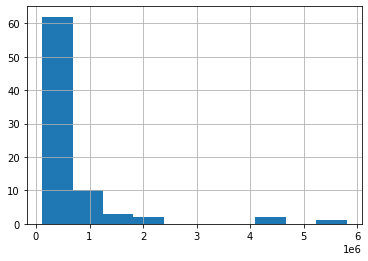

In [23]:
df['price'].hist()

## bed vs bath

<AxesSubplot:xlabel='bed', ylabel='bath'>

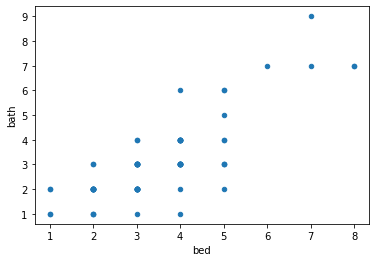

In [24]:
df.plot.scatter(x='bed',y='bath')